**Part 2 - Carpeting Detection**


In [ ]:
import pandas as pd
import os

from scipy import signal

import matplotlib.pyplot as plt

import numpy as np

from pydantic import BaseModel, Field
from typing import List

<Axes: >

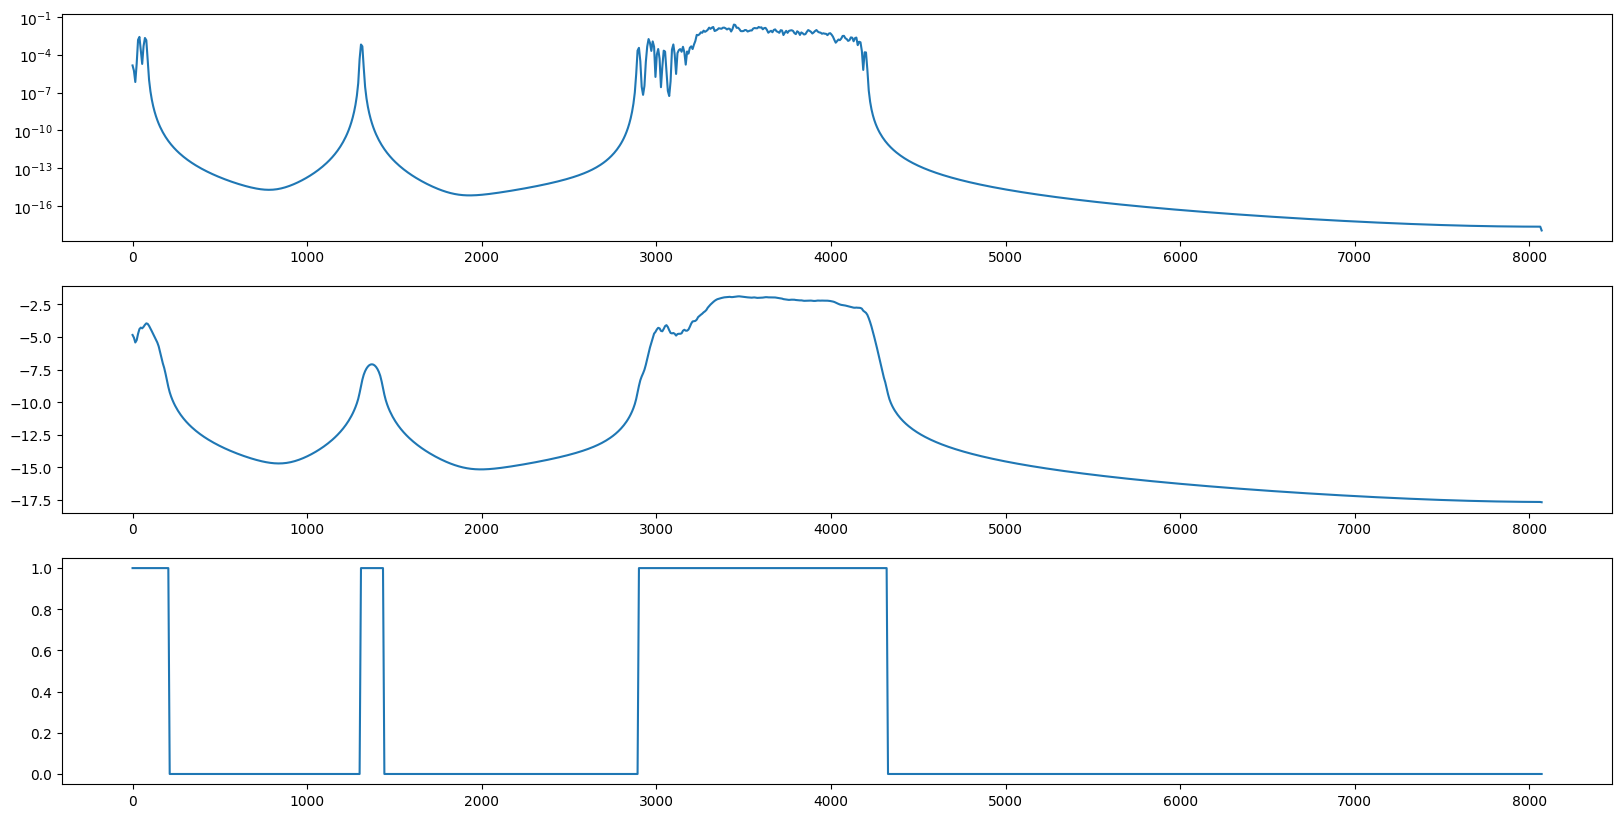

In [167]:
path = "./part_2/"
files = os.listdir(path)

data = pd.read_csv(path+files[10])

fs = data.shape[0] / data["t"].max()          # taxa de amostragem
f, Pxx = signal.welch(data["data"].to_numpy(), fs=fs, window='hann', nperseg=2048, noverlap=1024, scaling='density')

Pxx = pd.Series(Pxx,index=f)

fig,axs = plt.subplots(3,1,figsize=(20,10))
w = 16

axs[0].semilogy(f,Pxx)

loggedSignal = Pxx.apply(np.log10)



smoothedW = loggedSignal.rolling(min_periods=1,window=w).mean()
smoothedW.plot(ax=axs[1])

overPeaks = loggedSignal.loc[loggedSignal > loggedSignal.mean() + loggedSignal.std()]

carpets = ((smoothedW > (loggedSignal.mean() + loggedSignal.std() - overPeaks.std()))*1)
carpets.plot(ax=axs[2])

In [163]:
validCarpetsIntervals = carpets.loc[
    ((carpets != carpets.shift(1)) == True) &
    (carpets.index > 1000)
    ].index

In [165]:
[CarpetRegion(start_hz=validCarpetsIntervals[i-1],end_hz=validCarpetsIntervals[i]) for i in range(1,len(validCarpetsIntervals),2) if validCarpetsIntervals[i]-validCarpetsIntervals[i-1] > 150]
    

[CarpetRegion(start_hz=2900.2447584459974, end_hz=4326.7238380077515)]

In [ ]:
class CarpetRegion(BaseModel):
    start_hz: float = Field(..., description="Start frequency in Hz")
    end_hz: float = Field(..., description="End frequency in Hz")
class Wave(BaseModel):
    time: List[float] = Field(..., description="Time points of the wave")
    signal: List[float] = Field(..., description="Signal values")


class Model:
    def __init__(self, **params):
        # Store hyperparameters if needed
        self.params = params
    def predict(self, wave: Wave) -> List[CarpetRegion]:
        """
        Predict carpet regions from a given wave.
        This should be implemented with actual logic.
        """
        fs = Wave.signal.shape[0] / Wave.time.max() #sample rate
        f, Pxx = signal.welch(Wave.signal.to_numpy(), fs=fs, window=self.params["window"], nperseg=self.params["nperseg"], noverlap=self.params["noverlap"])
        Pxx = pd.Series(Pxx,index=f)
        
        loggedSignal = Pxx.apply(np.log10)

        smoothedW = loggedSignal.rolling(min_periods=1,window=self.params["rolling_window_size"]).mean()

        overPeaks = loggedSignal.loc[loggedSignal > loggedSignal.mean() + loggedSignal.std()]

        carpets = ((smoothedW > (loggedSignal.mean() + loggedSignal.std() - overPeaks.std()))*1)

        validCarpetsIntervals = carpets.loc[
            ((carpets != carpets.shift(1)) == True) &
            (carpets.index > 1000)
        ].index

        selectedCarpets =  [CarpetRegion(start_hz=validCarpetsIntervals[i-1],end_hz=validCarpetsIntervals[i]) for i in range(1,len(validCarpetsIntervals),2) if validCarpetsIntervals[i]-validCarpetsIntervals[i-1] > self.params["freq_threshold"]]

        return selectedCarpets


